In [3]:
# #!/bin/env python
# it takes about 3hr for one hemisphere
# rname=int(sys.argv[1])

In [82]:
import brainiak.eventseg.event
import numpy as np
import glob
import os
import scipy.io
from scipy.stats import stats
import logging
import matplotlib.pyplot as plt
from scipy.stats import norm, zscore, pearsonr
import pickle
import time
# this should finish in 3hr for one roi
# logging.basicConfig(level=logging.DEBUG)

In [83]:
expdir = '/scratch/claire/speaker-listener/'
timeUnit='tr'
froidir='mor';
exps=['pieman','bronx','merlin','sherlock']
rname='vPCUN'
eventN_test=range(10,121)
w=5

In [84]:
start_time = time.time()

# load mat file
for exp in [exps[2]]:
    for fname in  glob.glob(os.path.join(expdir + '/' + exp + '/fmri/timeseries/' + timeUnit + '/roi/' + froidir , 'zscore_listenerAll_'+rname+'.mat')):
        data_mat=scipy.io.loadmat(fname)
        gdata=data_mat['gdata']
        
        tn=gdata.shape[1]
        subjn=gdata.shape[2]
        voxn=gdata.shape[0]
        
        segments_others= np.empty((120,tn,subjn))
        segments_others[:]=np.nan
        segments_self= np.empty((120,tn,subjn))
        segments_self[:]=np.nan
        
        within_across_real = np.empty((max(eventN_test),subjn))
        within_across_real[:,:]=np.nan
        for s in range(subjn):
            if np.sum(~np.isnan(gdata[:,:,s]))>0:
                othersi=np.arange(subjn)
                othersi=othersi[othersi!=s]
                others=np.nanmean(gdata[:,:,othersi],axis=2)
                self=gdata[:,:,s]
                
                corrs = np.zeros(tn-w)
                for t in range(tn-w):
                    corrs[t] = pearsonr(self[:,t],self[:,t+w])[0]
                    
                for K in eventN_test:
                    Ki=K-1

                    # Find the events in this dataset
                    seg = brainiak.eventseg.event.EventSegment(K)
                    seg.fit(others.T) 

                    segments, _=seg.find_events(self.T);#, scramble=True)
                    events=segments.argmax(axis=1)+1

                    _, event_lengths = np.unique(events, return_counts=True)

                    # Compute within vs across boundary correlations, for real and permuted bounds
                    within = corrs[events[:-w] == events[w:]].mean()
                    across = corrs[events[:-w] != events[w:]].mean()
                    within_across_real[Ki, s] = within - across
            print(s)
     #   np.save(expdir +  exp+ '/fmri/hmm/'+ rname + '_ListenersLeave1Out_withinAcross_real.npy', within_across_real)      
print(time.time()-start_time)    
            #print('Subj ' + str(s+1) + ': WvsA = ' + str(within_across[s,0]))
    #    scipy.io.savemat(expdir +'/fMRI/' + '+exp/hmm/'+ 'rname' + '_hmm_ListenersLeave1Out.mat', {'segments_others':segments_others,'segments_self':segments_self})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
30698.192772865295


In [85]:
np.save(expdir +  exp+ '/fmri/hmm/'+ rname + '_ListenersLeave1Out_withinAcross_real.npy', within_across_real)

6


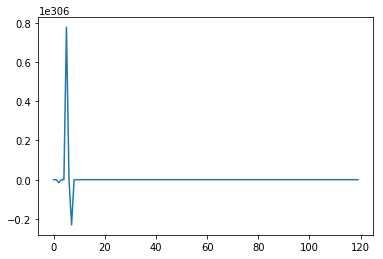

In [121]:
within_across_real=np.load(expdir +'bronx/fmri/hmm/vPCUN_ListenersLeave1Out_withinAcross_real.npy')
print(np.nanargmax(np.mean(within_across_real,axis=1))+1)

plt.plot(np.nanmean(within_across_real,axis=1))